# Gesture Recognition
## Project by V S S Anirudh Sharma
In this project, we will build a 3D Conv based model that will be able to predict the 5 gestures correctly.

In [33]:
import numpy as np
import os
# from scipy.ndimage import imread, imresize
from PIL import Image
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [34]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 32#experiment with the batch size
dim_x = dim_y = 100
selected_frames = range(0,30,2) #create a list of image numbers you want to use for a particular video

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
def normalize_frame(image):
  return (image-np.mean(image))/np.std(image)

In [ ]:
def generator(source_path, folder_list, batch_size, dim_x = dim_x,dim_y=dim_y,selected_frames = selected_frames, z_norm = False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = selected_frames
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size
        remaining_images = len(t)%batch_size
        x = len(img_idx)
        y,z = dim_x,dim_y

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in

                    image = Image.open(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    width, height = image.size
                    new_width = new_height = min(width, height)
                    left = (width - new_width)/2
                    top = (height - new_height)/2
                    right = (width + new_width)/2
                    bottom = (height + new_height)/2

                    # Crop the center of the image
                    image_cropped = image.crop((left, top, right, bottom))
                    image_resized = image_cropped.resize((dim_x,dim_y))

                    image_array = np.asarray(image_resized).astype(np.float32)

                    if z_norm:
                      batch_data[folder,idx,:,:,0] = normalize_frame(image_array[:,:,0])#normalise and feed in the image
                      batch_data[folder,idx,:,:,1] = normalize_frame(image_array[:,:,1])#normalise and feed in the image
                      batch_data[folder,idx,:,:,2] = normalize_frame(image_array[:,:,2])#normalise and feed in the image
                    else:
                      batch_data[folder,idx,:,:,0] = image_array[:,:,0]/255#normalise and feed in the image
                      batch_data[folder,idx,:,:,1] = image_array[:,:,1]/255#normalise and feed in the image
                      batch_data[folder,idx,:,:,2] = image_array[:,:,2]/255#normalise and feed in the image




                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        batch = num_batches
        batch_data = np.zeros((remaining_images,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((remaining_images,5)) # batch_labels is the one hot representation of the output
        for folder in range(remaining_images): # iterate over the batch_size
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in

                image = Image.open(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                #crop the images and resize them. Note that the images are of 2 different shape
                #and the conv3D will throw error if the inputs in a batch have different shapes

                width, height = image.size
                new_width = new_height = min(width, height)
                left = (width - new_width)/2
                top = (height - new_height)/2
                right = (width + new_width)/2
                bottom = (height + new_height)/2

                # Crop the center of the image
                image_cropped = image.crop((left, top, right, bottom))
                image_resized = image_cropped.resize((dim_x,dim_y))

                image_array = np.asarray(image_resized).astype(np.float32)

                if z_norm:
                  batch_data[folder,idx,:,:,0] = normalize_frame(image_array[:,:,0])#normalise and feed in the image
                  batch_data[folder,idx,:,:,1] = normalize_frame(image_array[:,:,1])#normalise and feed in the image
                  batch_data[folder,idx,:,:,2] = normalize_frame(image_array[:,:,2])#normalise and feed in the image
                else:
                  batch_data[folder,idx,:,:,0] = image_array[:,:,0]/255#normalise and feed in the image
                  batch_data[folder,idx,:,:,1] = image_array[:,:,1]/255#normalise and feed in the image
                  batch_data[folder,idx,:,:,2] = image_array[:,:,2]/255#normalise and feed in the image

            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do



Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Function to plot history

In [ ]:
import matplotlib.pyplot as plt
def plotHistory(history):
    plt.figure(figsize=(20,10))
    # Plot loss history
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy history
    plt.subplot(1, 2, 2)
    plt.plot(history.history['categorical_accuracy'], label='Training Categorical Accuracy')
    plt.plot(history.history['val_categorical_accuracy'], label='Validation Categorical Accuracy')
    plt.title('Accuracy History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Adjust spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()

In [ ]:
def plotHistoryConc(histories):
    final_history_loss = np.concatenate([history.history['loss'] for history in histories])
    final_history_val_loss = np.concatenate([history.history['val_loss'] for history in histories])
    final_history_categorical_accuracy = np.concatenate([history.history['categorical_accuracy'] for history in histories])
    final_history_val_categorical_accuracy = np.concatenate([history.history['val_categorical_accuracy'] for history in histories])
    plt.figure(figsize=(20,10))
    # Plot loss history
    plt.subplot(1, 2, 1)
    plt.plot(final_history_loss, label='Training Loss')
    plt.plot(final_history_val_loss, label='Validation Loss')
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy history
    plt.subplot(1, 2, 2)
    plt.plot(final_history_categorical_accuracy, label='Training Categorical Accuracy')
    plt.plot(final_history_val_categorical_accuracy, label='Validation Categorical Accuracy')
    plt.title('Accuracy History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Adjust spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
from keras.models import Sequential, Model

#from keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, Bidirectional, GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

# EXPERIMENT 1: Simple Conv3D
with only one layer

In [ ]:
x = len(selected_frames)
y, z = dim_x, dim_y
input_shape = (x, y, z, 3)
num_classes = 5

model0 = Sequential()
model0.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
model0.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model0.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu'))
# model0.add(MaxPooling3D(pool_size=(2, 2, 2)))
model0.add(Flatten())
model0.add(Dense(32, activation='relu'))
model0.add(Dense(num_classes, activation='softmax'))


2023-07-09 04:48:57.482363: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-07-09 04:48:57.482446: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:40:00.0, compute capability: 7.5


In [ ]:
optimiser = tf.keras.optimizers.Adam()#write your optimizer
model0.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model0.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 13, 98, 98, 16)    1312      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 49, 49, 16)    0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 230496)            0         
                                                                 
 dense (Dense)               (None, 32)                7375904   
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 7,377,381
Trainable params: 7,377,381
Non-trainable params: 0
______________________________________________

In [36]:
def get_model_size(model):
    total_size = 0
    for layer in model.layers:
        for param in layer.trainable_weights:
            total_size += param.shape.num_elements() * param.dtype.size
    return total_size


In [12]:
model_size = get_model_size(model0)
print("Model size: {:.2f} MB".format(model_size / (1024 * 1024)))

Model size: 28.14 MB


In [35]:
model_name = 'model_init_0' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [36]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [37]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [38]:
model0.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_304/2494116883.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model0.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 7.5268 - categorical_accuracy: 0.2489Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_0_2023-07-0603_03_40.826562/model-00001-7.52680-0.24887-1.50964-0.24000.h5
21/21 [==============================] - 41s 2s/step - loss: 7.5268 - categorical_accuracy: 0.2489 - val_loss: 1.5096 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 1.4687 - categorical_accuracy: 0.3514
Epoch 00002: saving model to model_init_0_2023-07-0603_03_40.826562/model-00002-1.46871-0.35143-1.34455-0.43000.h5
21/21 [==============================] - 37s 2s/step - loss: 1.4687 - categorical_accuracy: 0.3514 - val_loss: 1.3445 - val_categorical_accuracy: 0.4300 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 1.2981 - categorical_accur

In [39]:
num_epochs = 10
history0 = model0.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_304/2959787578.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history0 = model0.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 0.1323 - categorical_accuracy: 0.9864
Epoch 00001: saving model to model_init_0_2023-07-0603_03_40.826562/model-00001-0.13230-0.98643-0.54103-0.81000.h5
21/21 [==============================] - 37s 2s/step - loss: 0.1323 - categorical_accuracy: 0.9864 - val_loss: 0.5410 - val_categorical_accuracy: 0.8100 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 0.0691 - categorical_accuracy: 0.9985
Epoch 00002: saving model to model_init_0_2023-07-0603_03_40.826562/model-00002-0.06908-0.99849-0.89231-0.76000.h5
21/21 [==============================] - 35s 2s/step - loss: 0.0691 - categorical_accuracy: 0.9985 - val_loss: 0.8923 - val_categorical_accuracy: 0.7600 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 0.0455 - categorical_accuracy: 0.9970
Epoch 00003: saving model to model_init_0_2023-07-0603_03_40.826562/model-00003-0.04554-0.99698-0.71252-0.81000.h5
21/21

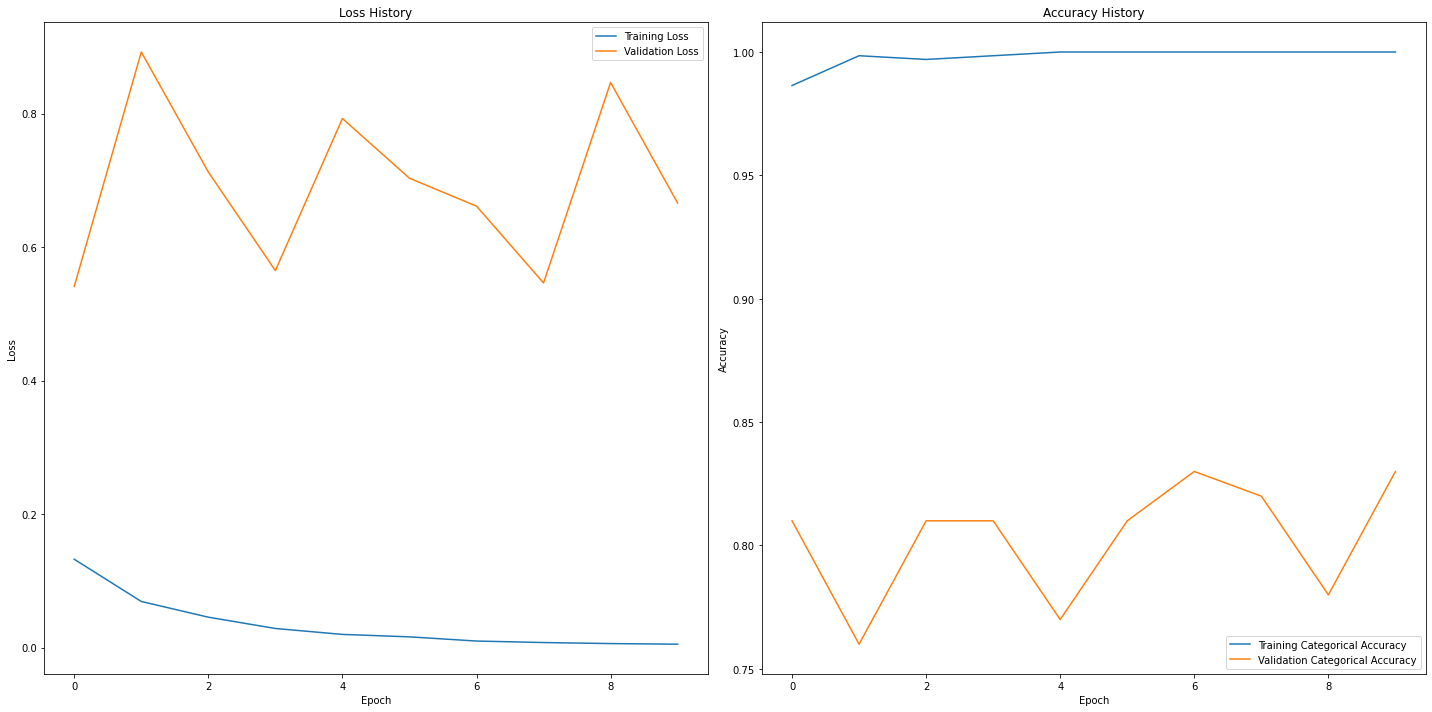

In [41]:
plotHistory(history0)

## Observations:
1. The models best behaviour is 100% training and 83% validation accuracy
2. Overfitting

## TODO:
1. Reduce overfitting
2. Introduce dropout layer

# EXPERIMENT 2: Simple Conv3D with dropouts

In [42]:
x = len(selected_frames)
y, z = dim_x, dim_y
input_shape = (x, y, z, 3)
num_classes = 5

model1 = Sequential()
model1.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))
model1.add(Dropout(0.5))
# model0.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu'))
# model0.add(MaxPooling3D(pool_size=(2, 2, 2)))
model1.add(Flatten())
model1.add(Dense(32, activation='relu'))
model1.add(Dense(num_classes, activation='softmax'))

In [43]:
optimiser = tf.keras.optimizers.Adam()#write your optimizer
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_10 (Conv3D)          (None, 13, 98, 98, 16)    1312      
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 6, 49, 49, 16)    0         
 g3D)                                                            
                                                                 
 dropout (Dropout)           (None, 6, 49, 49, 16)     0         
                                                                 
 flatten_6 (Flatten)         (None, 230496)            0         
                                                                 
 dense_11 (Dense)            (None, 32)                7375904   
                                                                 
 dense_12 (Dense)            (None, 5)                 165       
                                                      

In [44]:
model_name = 'model_init_1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [45]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [46]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [47]:
num_epochs = 20
history1 = model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_304/1194083571.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 2.9070 - categorical_accuracy: 0.2187Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_1_2023-07-0603_03_40.826562/model-00001-2.90704-0.21870-1.59696-0.15000.h5
21/21 [==============================] - 40s 2s/step - loss: 2.9070 - categorical_accuracy: 0.2187 - val_loss: 1.5970 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.4875 - categorical_accuracy: 0.2805
Epoch 00002: saving model to model_init_1_2023-07-0603_03_40.826562/model-00002-1.48751-0.28054-1.38551-0.44000.h5
21/21 [==============================] - 36s 2s/step - loss: 1.4875 - categorical_accuracy: 0.2805 - val_loss: 1.3855 - val_categorical_accuracy: 0.4400 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.1406 - categorical_accur

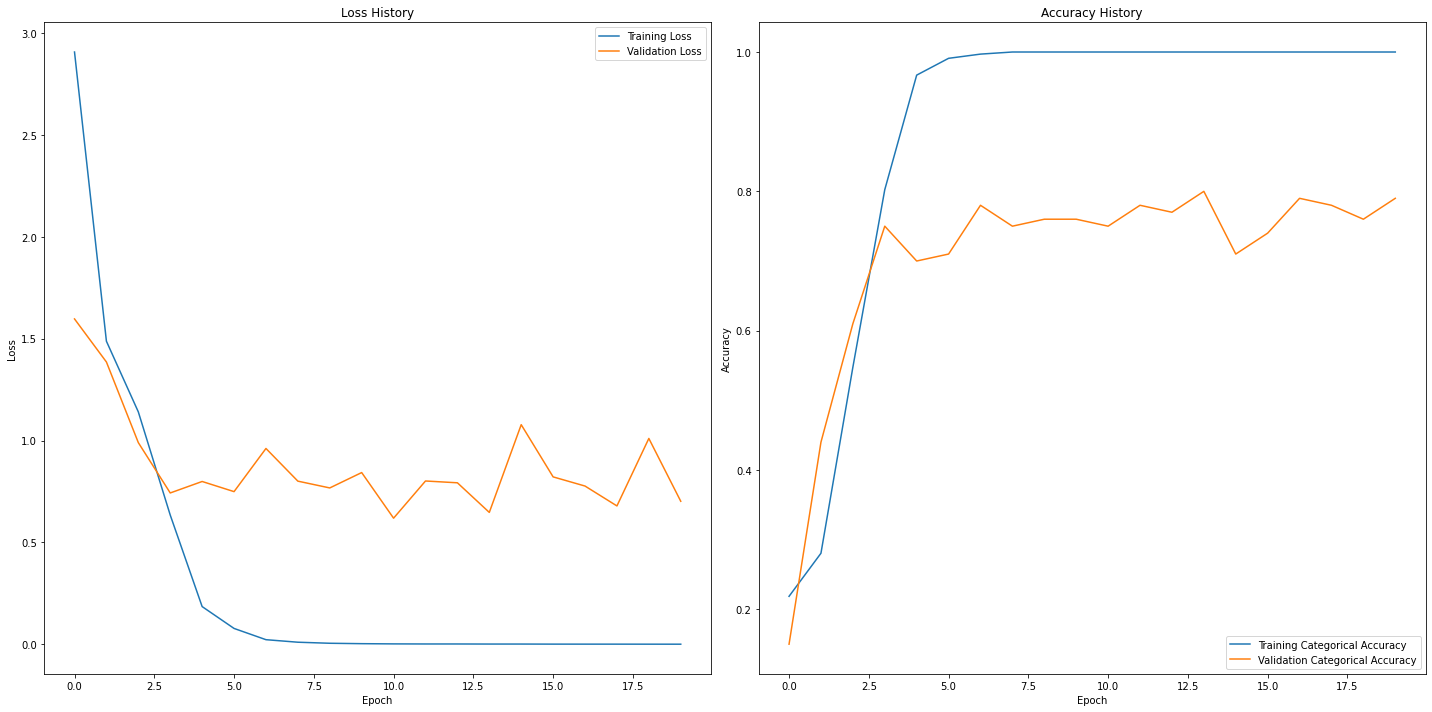

In [48]:
plotHistory(history1)

## Observations:
1. The models best behaviour is 100% training and 80% validation accuracy
2. Worse off

## TODO:
1. Reduce dropout ratio

# EXPERIMENT 3: Conv3D with reduced dropout

In [49]:
x = len(selected_frames)
y, z = dim_x, dim_y
input_shape = (x, y, z, 3)
num_classes = 5

model2 = Sequential()
model2.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(Dropout(0.2))
# model0.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu'))
# model0.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(Flatten())
model2.add(Dense(32, activation='relu'))
model2.add(Dense(num_classes, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [50]:
optimiser = tf.keras.optimizers.Adam()#write your optimizer
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_11 (Conv3D)          (None, 13, 98, 98, 16)    1312      
                                                                 
 max_pooling3d_11 (MaxPoolin  (None, 6, 49, 49, 16)    0         
 g3D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 49, 49, 16)     0         
                                                                 
 flatten_7 (Flatten)         (None, 230496)            0         
                                                                 
 dense_13 (Dense)            (None, 32)                7375904   
                                                                 
 dense_14 (Dense)            (None, 5)                 165       
                                                      

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [51]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [52]:
model_name = 'model_init_2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [53]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [54]:
num_epochs = 20
history2 = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_304/2668389603.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 5.1435 - categorical_accuracy: 0.1900Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2_2023-07-0603_03_40.826562/model-00001-5.14354-0.19005-1.61164-0.20000.h5
21/21 [==============================] - 37s 2s/step - loss: 5.1435 - categorical_accuracy: 0.1900 - val_loss: 1.6116 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5875 - categorical_accuracy: 0.2353
Epoch 00002: saving model to model_init_2_2023-07-0603_03_40.826562/model-00002-1.58753-0.23529-1.58992-0.22000.h5
21/21 [==============================] - 38s 2s/step - loss: 1.5875 - categorical_accuracy: 0.2353 - val_loss: 1.5899 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.4549 - categorical_accur

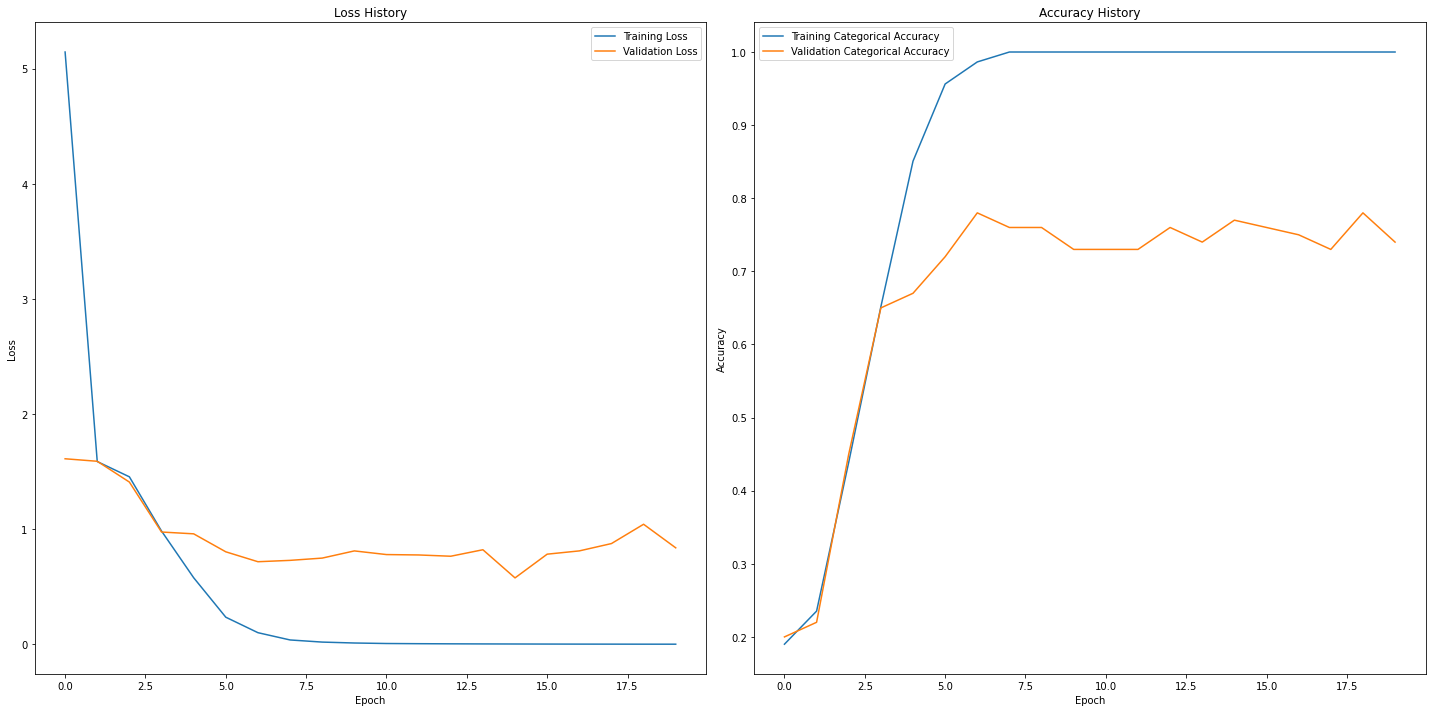

In [55]:
plotHistory(history2)

## Observations
1. Best model has given 100% training accuracy and 78% validation accuracy.
2. We are worse off.

## TODO:
Let's revert back add l2 regularization on conv3d layer

## Experiment 4: Conv3D: L2 regularization

In [63]:
x = len(selected_frames)
y, z = dim_x, dim_y
input_shape = (x, y, z, 3)
num_classes = 5

model3 = Sequential()
model3.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape,kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model0.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu'))
# model0.add(MaxPooling3D(pool_size=(2, 2, 2)))
model3.add(Flatten())
model3.add(Dense(32, activation='relu'))
model3.add(Dense(num_classes, activation='softmax'))

In [64]:
optimiser = tf.keras.optimizers.Adam()#write your optimizer
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_13 (Conv3D)          (None, 13, 98, 98, 16)    1312      
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 6, 49, 49, 16)    0         
 g3D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 230496)            0         
                                                                 
 dense_17 (Dense)            (None, 32)                7375904   
                                                                 
 dense_18 (Dense)            (None, 5)                 165       
                                                                 
Total params: 7,377,381
Trainable params: 7,377,381
Non-trainable params: 0
___________________________________________

In [65]:
model_name = 'model_init_3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [66]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [67]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [68]:
num_epochs = 15
history3 = model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_304/2520328596.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history3 = model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 8.2989 - categorical_accuracy: 0.2368Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_3_2023-07-0603_03_40.826562/model-00001-8.29887-0.23680-1.53415-0.25000.h5
21/21 [==============================] - 37s 2s/step - loss: 8.2989 - categorical_accuracy: 0.2368 - val_loss: 1.5341 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.3592 - categorical_accuracy: 0.3967
Epoch 00002: saving model to model_init_3_2023-07-0603_03_40.826562/model-00002-1.35919-0.39668-1.15142-0.56000.h5
21/21 [==============================] - 37s 2s/step - loss: 1.3592 - categorical_accuracy: 0.3967 - val_loss: 1.1514 - val_categorical_accuracy: 0.5600 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 0.7715 - categorical_accur

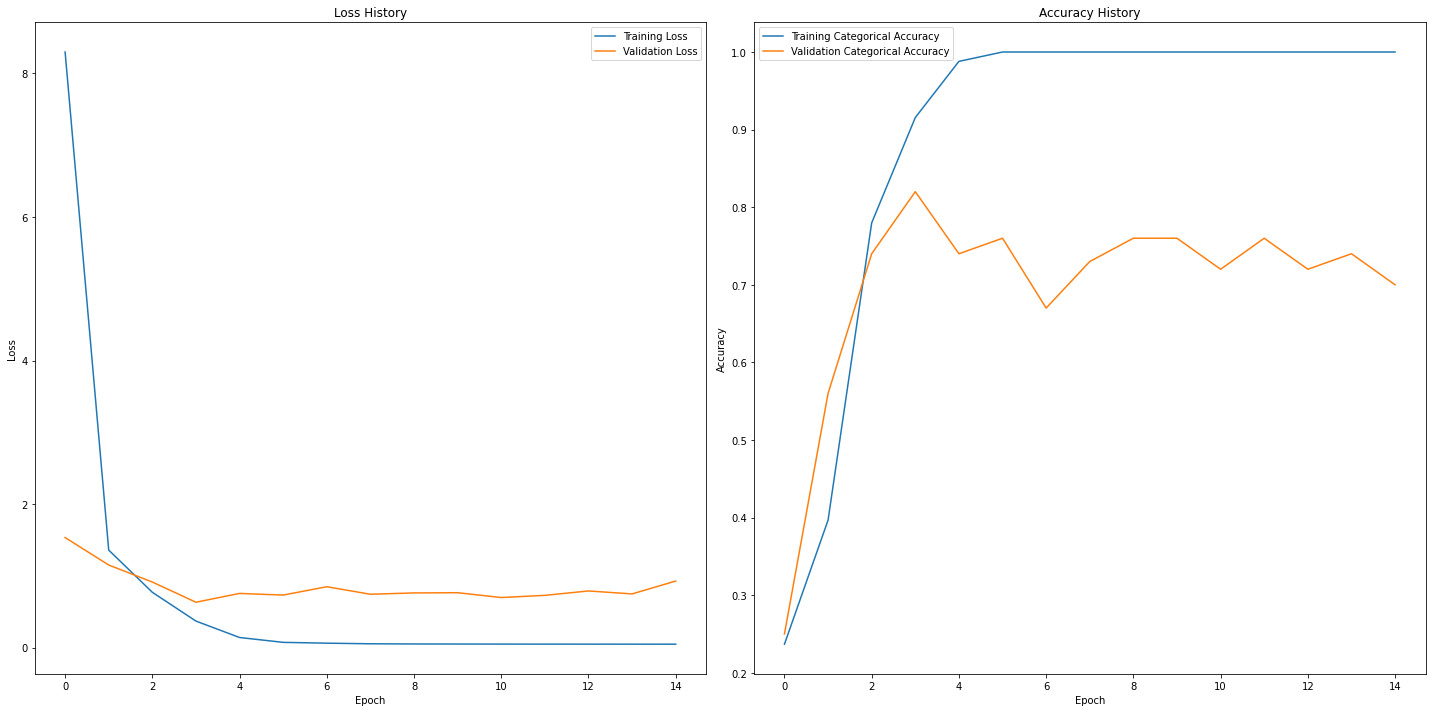

In [69]:
plotHistory(history3)

## Observations:
1. Best result: 100% train and 82% test accuracy
2. Mild overfitting

## TODO
Let's try to reduce model complexity

## Experiment 5: Super Simple Model

In [16]:
x = len(selected_frames)
y, z = dim_x, dim_y
input_shape = (x, y, z, 3)
num_classes = 5

model5 = Sequential()
model5.add(Conv3D(8, kernel_size=(4, 4, 4), activation='relu', input_shape=input_shape))
model5.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model5.add(Dropout(0.2))
# model0.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu'))
# model0.add(MaxPooling3D(pool_size=(2, 2, 2)))
model5.add(Flatten())
# model5.add(Dense(32, activation='relu'))
model5.add(Dense(num_classes, activation='softmax'))

In [17]:
optimiser = tf.keras.optimizers.Adam()#write your optimizer
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 12, 97, 97, 8)     1544      
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 6, 48, 48, 8)     0         
 3D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 110592)            0         
                                                                 
 dense_3 (Dense)             (None, 5)                 552965    
                                                                 
Total params: 554,509
Trainable params: 554,509
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
model_size = get_model_size(model5)
print("Model size: {:.2f} MB".format(model_size / (1024 * 1024)))

Model size: 2.12 MB


In [19]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [20]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [21]:
model_name = 'model_init_simpe1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [22]:
num_epochs = 15
history5 = model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_303/3808218697.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history5 = model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/15


2023-07-08 12:15:23.415992: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 3.2609 - categorical_accuracy: 0.1991Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_simpe1_2023-07-0812_14_08.363848/model-00001-3.26087-0.19910-1.39032-0.26000.h5
21/21 [==============================] - 42s 2s/step - loss: 3.2609 - categorical_accuracy: 0.1991 - val_loss: 1.3903 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.2861 - categorical_accuracy: 0.4103
Epoch 00002: saving model to model_init_simpe1_2023-07-0812_14_08.363848/model-00002-1.28611-0.41026-1.34950-0.42000.h5
21/21 [==============================] - 39s 2s/step - loss: 1.2861 - categorical_accuracy: 0.4103 - val_loss: 1.3495 - val_categorical_accuracy: 0.4200 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 1.0096 - categorical_accuracy: 0.6712
Epoch 00003: saving model to model_init_simpe1_2023-07-0

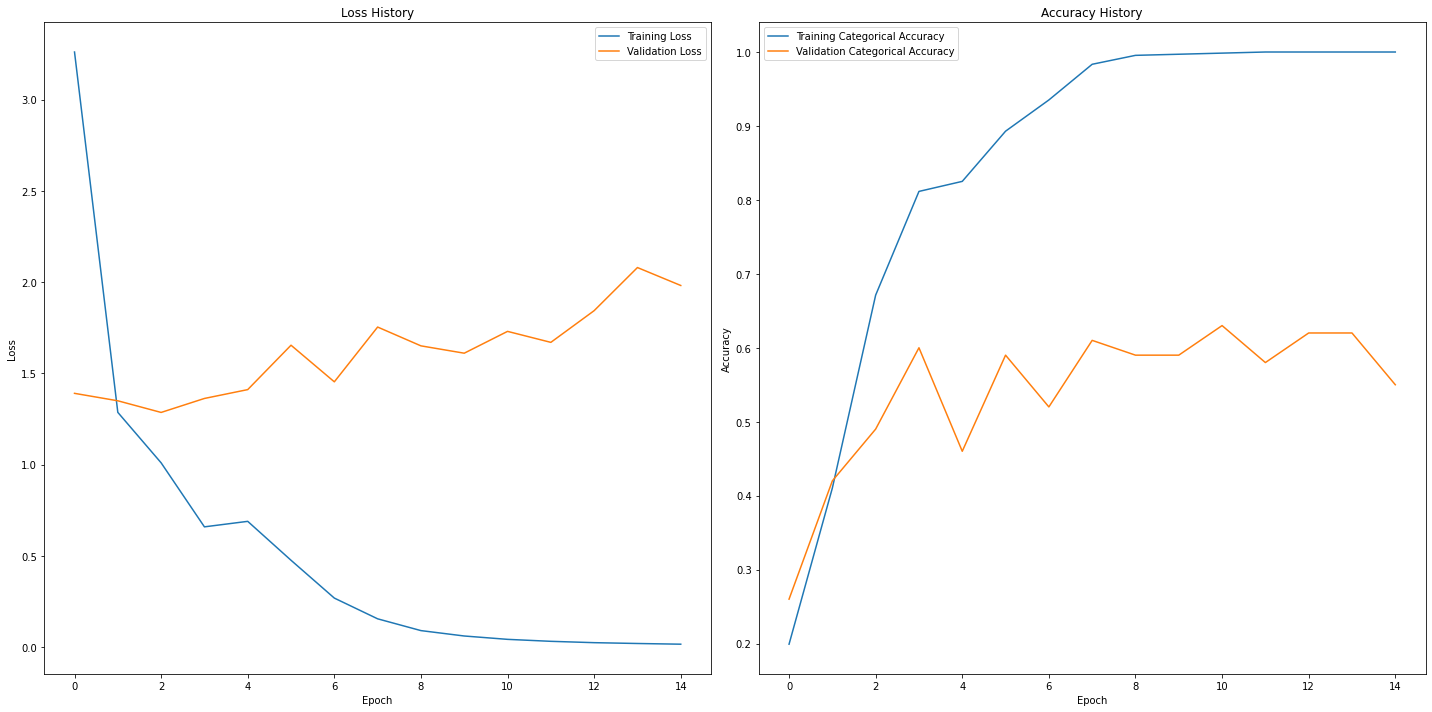

In [23]:
plotHistory(history5)

## Observation
1. Best model 60% val and 100% training accuracy
2. Heavy Overfitting

## TODO
1. Reduce model complexity to reduce overfitting

## Experiment 6: Increased Pool Size

In [24]:
x = len(selected_frames)
y, z = dim_x, dim_y
input_shape = (x, y, z, 3)
num_classes = 5

model6 = Sequential()
model6.add(Conv3D(8, kernel_size=(4, 4, 4), activation='relu', input_shape=input_shape))
model6.add(MaxPooling3D(pool_size=(4, 4, 4)))
# model5.add(Dropout(0.2))
# model0.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu'))
# model0.add(MaxPooling3D(pool_size=(2, 2, 2)))
model6.add(Flatten())
# model5.add(Dense(32, activation='relu'))
model6.add(Dense(num_classes, activation='softmax'))

In [25]:
optimiser = tf.keras.optimizers.Adam()#write your optimizer
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model6.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 12, 97, 97, 8)     1544      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 3, 24, 24, 8)     0         
 3D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 13824)             0         
                                                                 
 dense_4 (Dense)             (None, 5)                 69125     
                                                                 
Total params: 70,669
Trainable params: 70,669
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
model_size = get_model_size(model6)
print("Model size: {:.2f} MB".format(model_size / (1024 * 1024)))

Model size: 0.27 MB


In [27]:
model_name = 'model_init_simpe2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [28]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [29]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [30]:
num_epochs = 20
history6 = model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_303/3175259047.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history6 = model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.5023 - categorical_accuracy: 0.2941Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_simpe2_2023-07-0812_14_08.363848/model-00001-1.50232-0.29412-1.22280-0.47000.h5
21/21 [==============================] - 43s 2s/step - loss: 1.5023 - categorical_accuracy: 0.2941 - val_loss: 1.2228 - val_categorical_accuracy: 0.4700 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.0281 - categorical_accuracy: 0.6229
Epoch 00002: saving model to model_init_simpe2_2023-07-0812_14_08.363848/model-00002-1.02813-0.62293-1.05323-0.56000.h5
21/21 [==============================] - 41s 2s/step - loss: 1.0281 - categorical_accuracy: 0.6229 - val_loss: 1.0532 - val_categorical_accuracy: 0.5600 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.7750 - categor

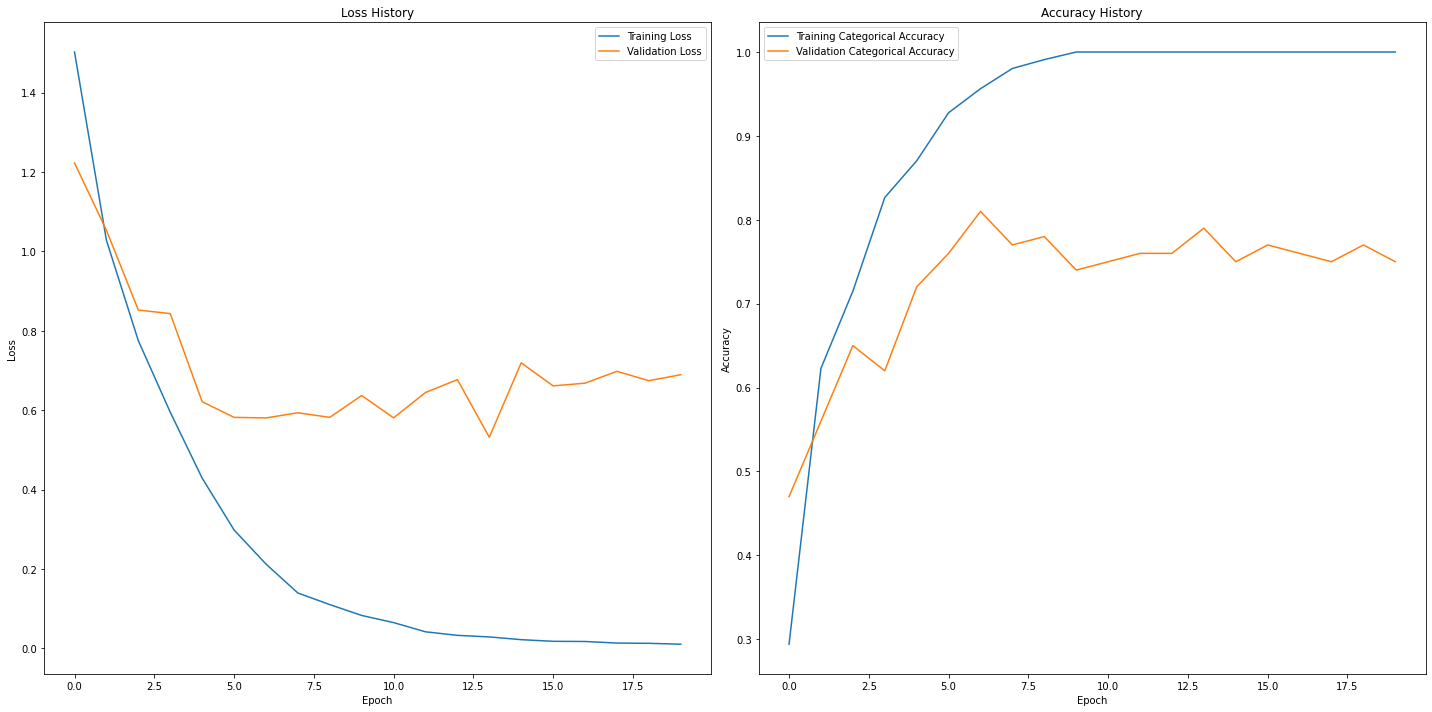

In [31]:
plotHistory(history6)

## observation
1. Best model 81% val and 96% Training accuracy
2. Still overfitting

## TODO
Add dropouts

## Experiment 7: Add dropout

In [13]:
x = len(selected_frames)
y, z = dim_x, dim_y
input_shape = (x, y, z, 3)
num_classes = 5

model7 = Sequential()
model7.add(Conv3D(8, kernel_size=(4, 4, 4), activation='relu', input_shape=input_shape))
model7.add(Dropout(0.5))
model7.add(MaxPooling3D(pool_size=(4, 4, 4)))

# model0.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu'))
# model0.add(MaxPooling3D(pool_size=(2, 2, 2)))
model7.add(Flatten())
# model5.add(Dense(32, activation='relu'))
model7.add(Dense(num_classes, activation='softmax'))

In [14]:
optimiser = tf.keras.optimizers.Adam()#write your optimizer
model7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model7.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_1 (Conv3D)           (None, 12, 97, 97, 8)     1544      
                                                                 
 dropout (Dropout)           (None, 12, 97, 97, 8)     0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 3, 24, 24, 8)     0         
 3D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 13824)             0         
                                                                 
 dense_2 (Dense)             (None, 5)                 69125     
                                                                 
Total params: 70,669
Trainable params: 70,669
Non-trainable params: 0
__________________________________________________

In [18]:
model_size = get_model_size(model7)
print("Model size: {:.2f} MB".format(model_size / (1024 * 1024)))

Model size: 0.27 MB


In [19]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [20]:
model_name = 'model_init_simple3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [21]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [22]:
num_epochs = 15
history7 = model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_301/1232246185.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history7 = model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/15


2023-07-09 04:54:48.342361: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.4795 - categorical_accuracy: 0.2217Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_simple3_2023-07-0904_48_54.414710/model-00001-1.47954-0.22172-1.37250-0.38000.h5
21/21 [==============================] - 35s 2s/step - loss: 1.4795 - categorical_accuracy: 0.2217 - val_loss: 1.3725 - val_categorical_accuracy: 0.3800 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.0709 - categorical_accuracy: 0.5762
Epoch 00002: saving model to model_init_simple3_2023-07-0904_48_54.414710/model-00002-1.07093-0.57617-1.11948-0.66000.h5
21/21 [==============================] - 34s 2s/step - loss: 1.0709 - categorical_accuracy: 0.5762 - val_loss: 1.1195 - val_categorical_accuracy: 0.6600 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 0.6727 - categorical_accuracy: 0.7738
Epoch 00003: saving model to model_init_simple3_2023-0

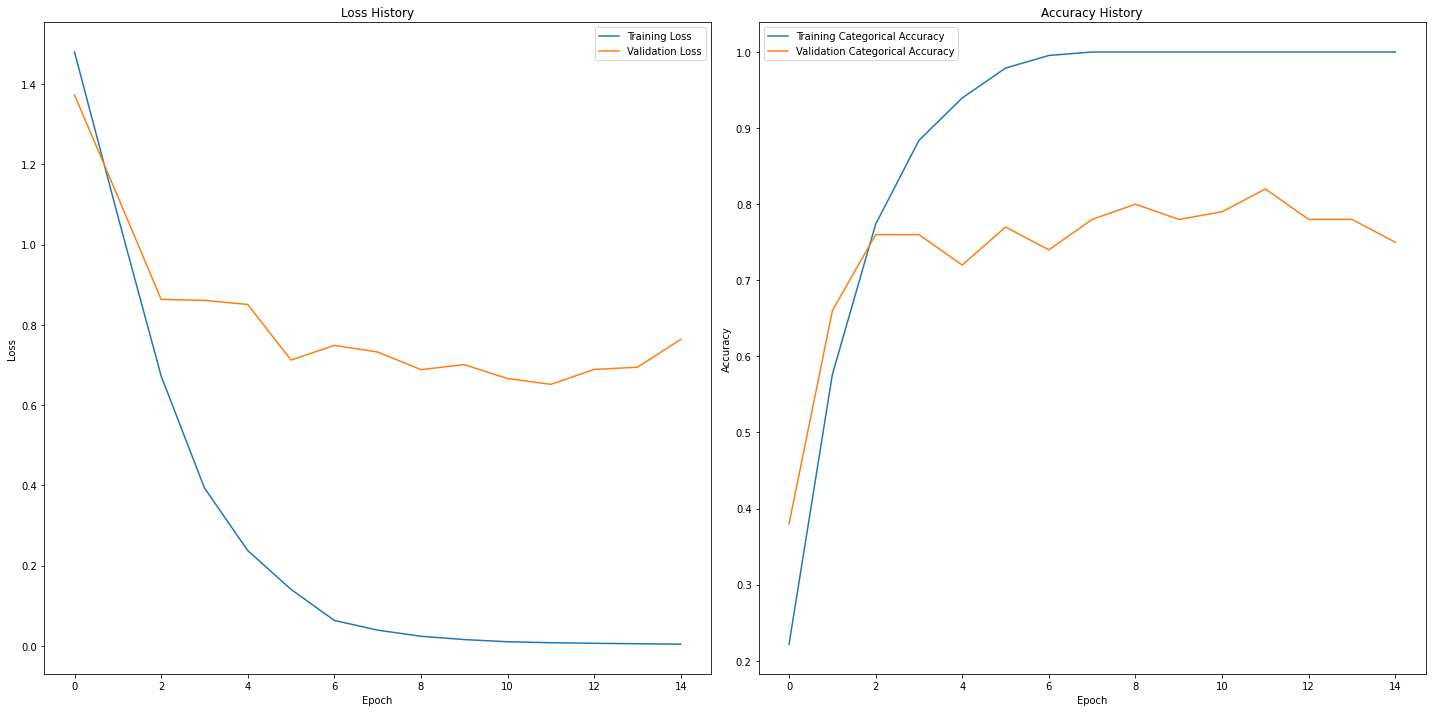

In [23]:
plotHistory(history7)

## observation
1. Again we have similar results
2. 100% training and 82% validation accuracy
3. Overfitting

## TODO
1. Try padding


## Experiment 9: Padding

In [26]:
x = len(selected_frames)
y, z = dim_x, dim_y
input_shape = (x, y, z, 3)
num_classes = 5

model8 = Sequential()
model8.add(Conv3D(8, kernel_size=(4, 4, 4), activation='relu', input_shape=input_shape,padding = 'same'))
model8.add(Dropout(0.5))
model8.add(MaxPooling3D(pool_size=(4, 4, 4)))

# model0.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu'))
# model0.add(MaxPooling3D(pool_size=(2, 2, 2)))
model8.add(Flatten())
# model5.add(Dense(32, activation='relu'))
model8.add(Dense(num_classes, activation='softmax'))#, kernel_regularizer=tf.keras.regularizers.l2(0.01)))

In [31]:
model_size = get_model_size(model8)
print("Model size: {:.2f} MB".format(model_size / (1024 * 1024)))

Model size: 0.29 MB


In [27]:
optimiser = tf.keras.optimizers.Adam()#write your optimizer
model8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model8.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 15, 100, 100, 8)   1544      
                                                                 
 dropout_2 (Dropout)         (None, 15, 100, 100, 8)   0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 3, 25, 25, 8)     0         
 3D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 15000)             0         
                                                                 
 dense_4 (Dense)             (None, 5)                 75005     
                                                                 
Total params: 76,549
Trainable params: 76,549
Non-trainable params: 0
__________________________________________________

In [32]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [33]:
model_name = 'model_init_simple4' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [34]:
num_epochs = 20
history8 = model8.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_301/4138287960.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history8 = model8.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.4419 - categorical_accuracy: 0.3771Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_simple4_2023-07-0904_48_54.414710/model-00001-1.44191-0.37707-1.35579-0.50000.h5
21/21 [==============================] - 35s 2s/step - loss: 1.4419 - categorical_accuracy: 0.3771 - val_loss: 1.3558 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 0.9554 - categorical_accuracy: 0.6440
Epoch 00002: saving model to model_init_simple4_2023-07-0904_48_54.414710/model-00002-0.95536-0.64404-1.08575-0.62000.h5
21/21 [==============================] - 34s 2s/step - loss: 0.9554 - categorical_accuracy: 0.6440 - val_loss: 1.0857 - val_categorical_accuracy: 0.6200 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.6213 - categ

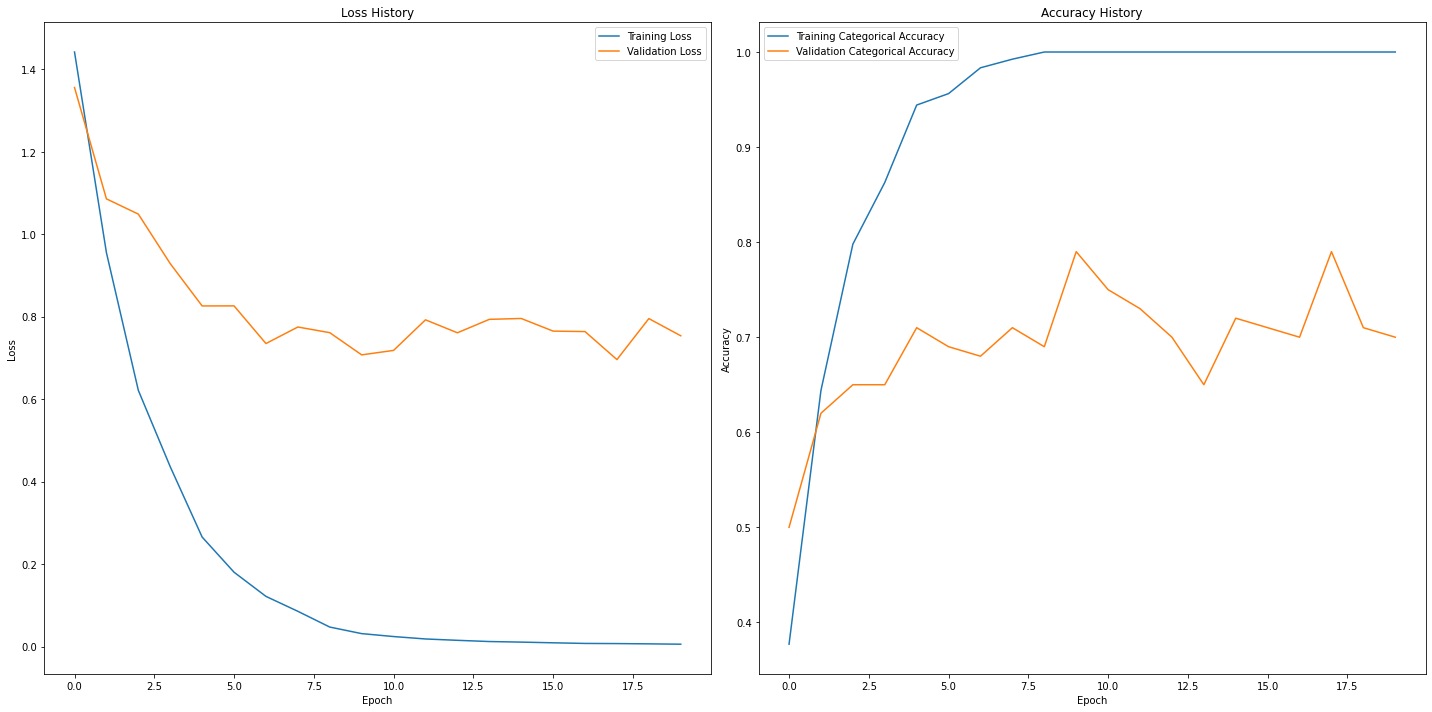

In [35]:
plotHistory(history8)

## observation
1. Padding didn't really help, moreover increasing the size of the model.

## TODO
1. Reduce complexity


## Experiment 10: Reduced complexity

In [74]:
x = len(selected_frames)
y, z = dim_x, dim_y
input_shape = (x, y, z, 3)
num_classes = 5

model9 = Sequential()
model9.add(Conv3D(4, kernel_size=(4, 4, 4), activation='relu', input_shape=input_shape))#,kernel_regularizer=tf.keras.regularizers.l2(0.1)))
# model9.add(Dropout(0.9))
model9.add(MaxPooling3D(pool_size=(4, 4, 4)))

# model0.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu'))
# model0.add(MaxPooling3D(pool_size=(2, 2, 2)))
model9.add(Flatten())
# model5.add(Dense(32, activation='relu'))
model9.add(Dense(num_classes, activation='softmax'))#, kernel_regularizer=tf.keras.regularizers.l2(0.01)))

In [75]:
optimiser = tf.keras.optimizers.Adam()#write your optimizer
model9.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model9.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 12, 97, 97, 4)     772       
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 3, 24, 24, 4)     0         
 3D)                                                             
                                                                 
 flatten_9 (Flatten)         (None, 6912)              0         
                                                                 
 dense_10 (Dense)            (None, 5)                 34565     
                                                                 
Total params: 35,337
Trainable params: 35,337
Non-trainable params: 0
_________________________________________________________________
None


In [76]:
model_size = get_model_size(model9)
print("Model size: {:.2f} MB".format(model_size / (1024 * 1024)))

Model size: 0.13 MB


In [80]:
model_name = 'model_init_simple5' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [81]:
train_generator = generator(train_path, train_doc, batch_size,z_norm = True)
val_generator = generator(val_path, val_doc, batch_size,z_norm = True)

In [82]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [83]:
num_epochs = 15
history9 = model9.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_301/3622210814.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history9 = model9.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 1.9621 - categorical_accuracy: 0.3348Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_simple5_2023-07-0904_48_54.414710/model-00001-1.96209-0.33484-1.26465-0.47000.h5
21/21 [==============================] - 37s 2s/step - loss: 1.9621 - categorical_accuracy: 0.3348 - val_loss: 1.2646 - val_categorical_accuracy: 0.4700 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 0.9892 - categorical_accuracy: 0.6290
Epoch 00002: saving model to model_init_simple5_2023-07-0904_48_54.414710/model-00002-0.98923-0.62896-1.14698-0.65000.h5
21/21 [==============================] - 36s 2s/step - loss: 0.9892 - categorical_accuracy: 0.6290 - val_loss: 1.1470 - val_categorical_accuracy: 0.6500 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 0.7196 - categ

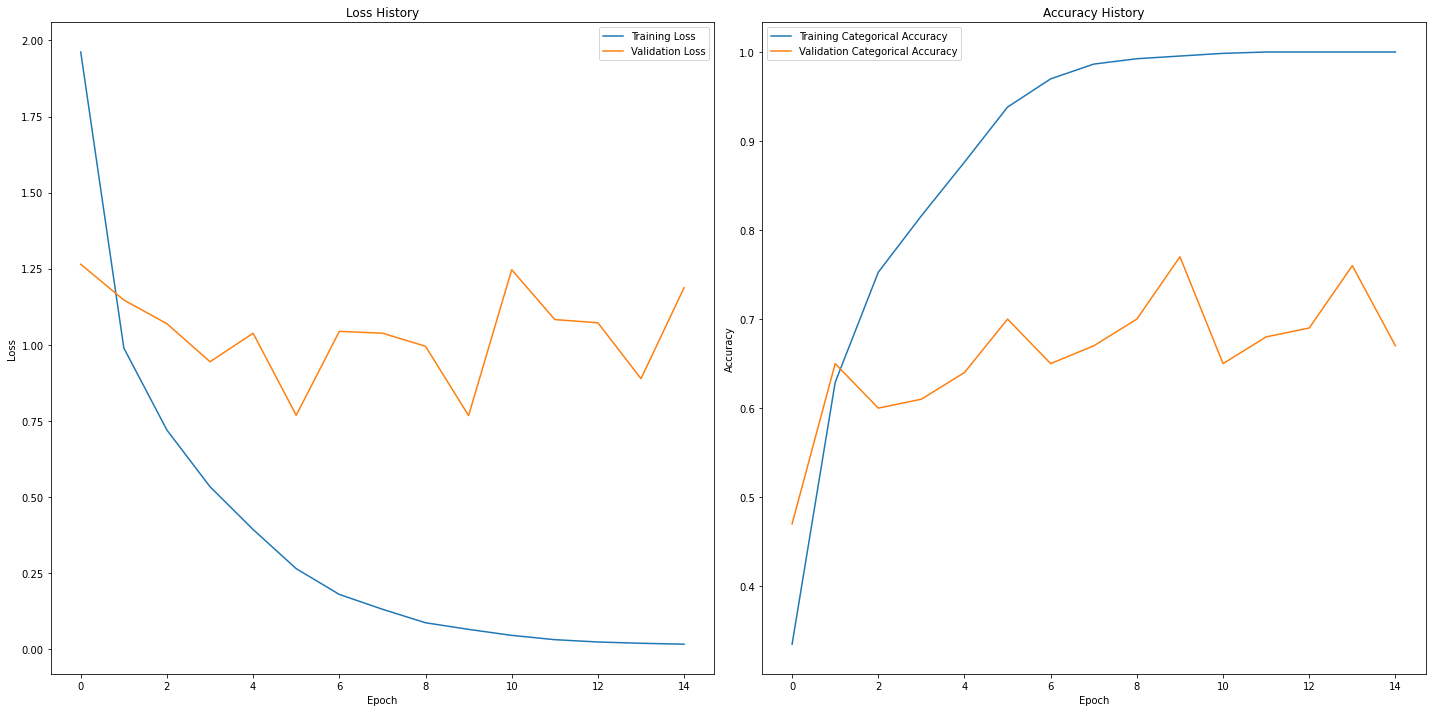

In [84]:
plotHistory(history9)

## observation
1. Best model 100% train and ~77% val accuracy.
2. overfitting

## Hypothesis
Add dropouts



## Experiment 11: Add dropout

In [85]:
x = len(selected_frames)
y, z = dim_x, dim_y
input_shape = (x, y, z, 3)
num_classes = 5

model10 = Sequential()
model10.add(Conv3D(4, kernel_size=(4, 4, 4), activation='relu', input_shape=input_shape))#,kernel_regularizer=tf.keras.regularizers.l2(0.1)))
model10.add(MaxPooling3D(pool_size=(4, 4, 4)))
model10.add(Dropout(0.9))

# model0.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu'))
# model0.add(MaxPooling3D(pool_size=(2, 2, 2)))
model10.add(Flatten())
# model5.add(Dense(32, activation='relu'))
model10.add(Dense(num_classes, activation='softmax'))#, kernel_regularizer=tf.keras.regularizers.l2(0.01)))

In [86]:
optimiser = tf.keras.optimizers.Adam()#write your optimizer
model10.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model10.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_10 (Conv3D)          (None, 12, 97, 97, 4)     772       
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 3, 24, 24, 4)     0         
 g3D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 3, 24, 24, 4)      0         
                                                                 
 flatten_10 (Flatten)        (None, 6912)              0         
                                                                 
 dense_11 (Dense)            (None, 5)                 34565     
                                                                 
Total params: 35,337
Trainable params: 35,337
Non-trainable params: 0
_________________________________________________

In [87]:
model_name = 'model_init_simple6' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [88]:
model_size = get_model_size(model10)
print("Model size: {:.2f} MB".format(model_size / (1024 * 1024)))

Model size: 0.13 MB


In [89]:
num_epochs = 15
history10 = model10.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_301/1552469654.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history10 = model10.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 3.4500 - categorical_accuracy: 0.1946
Epoch 00001: saving model to model_init_simple6_2023-07-0904_48_54.414710/model-00001-3.45005-0.19457-1.49053-0.39000.h5
21/21 [==============================] - 35s 2s/step - loss: 3.4500 - categorical_accuracy: 0.1946 - val_loss: 1.4905 - val_categorical_accuracy: 0.3900 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 2.3776 - categorical_accuracy: 0.2655
Epoch 00002: saving model to model_init_simple6_2023-07-0904_48_54.414710/model-00002-2.37765-0.26546-1.37033-0.44000.h5
21/21 [==============================] - 37s 2s/step - loss: 2.3776 - categorical_accuracy: 0.2655 - val_loss: 1.3703 - val_categorical_accuracy: 0.4400 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 1.8171 - categorical_accuracy: 0.3363
Epoch 00003: saving model to model_init_simple6_2023-07-0904_48_54.414710/model-00003-1.81714-0.33635-1.2773

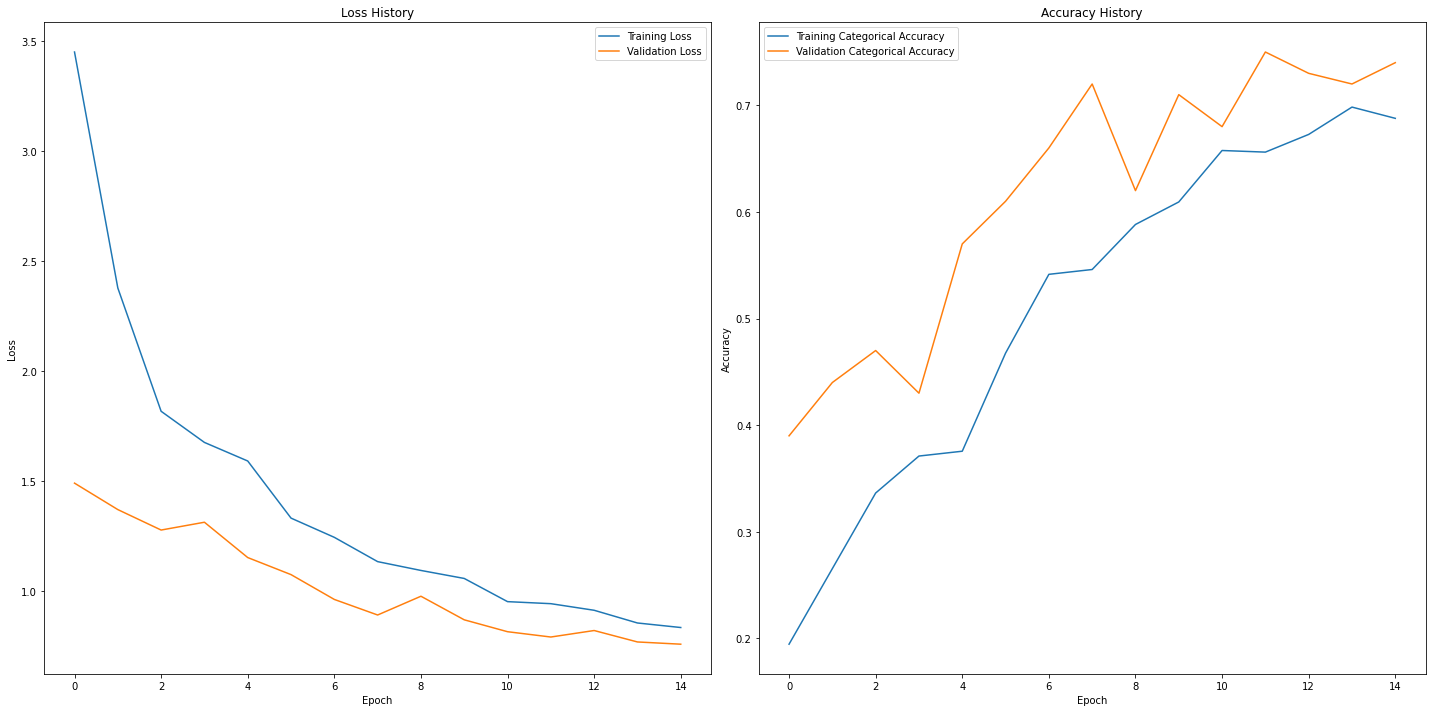

In [90]:
plotHistory(history10)

/tmp/ipykernel_301/3953399586.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history10_1 = model10.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 0.7745 - categorical_accuracy: 0.7089
Epoch 00001: saving model to model_init_simple6_2023-07-0904_48_54.414710/model-00001-0.77448-0.70890-0.79104-0.72000.h5
21/21 [==============================] - 36s 2s/step - loss: 0.7745 - categorical_accuracy: 0.7089 - val_loss: 0.7910 - val_categorical_accuracy: 0.7200 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 0.7940 - categorical_accuracy: 0.7210
Epoch 00002: saving model to model_init_simple6_2023-07-0904_48_54.414710/model-00002-0.79401-0.72097-0.70520-0.72000.h5
21/21 [==============================] - 35s 2s/step - loss: 0.7940 - categorical_accuracy: 0.7210 - val_loss: 0.7052 - val_categorical_accuracy: 0.7200 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 0.7219 - categorical_accuracy: 0.7270
Epoch 00003: saving model to model_init_simple6_2023-07-0904_48_54.414710/model-00003-0.72188-0.72700-0.7238

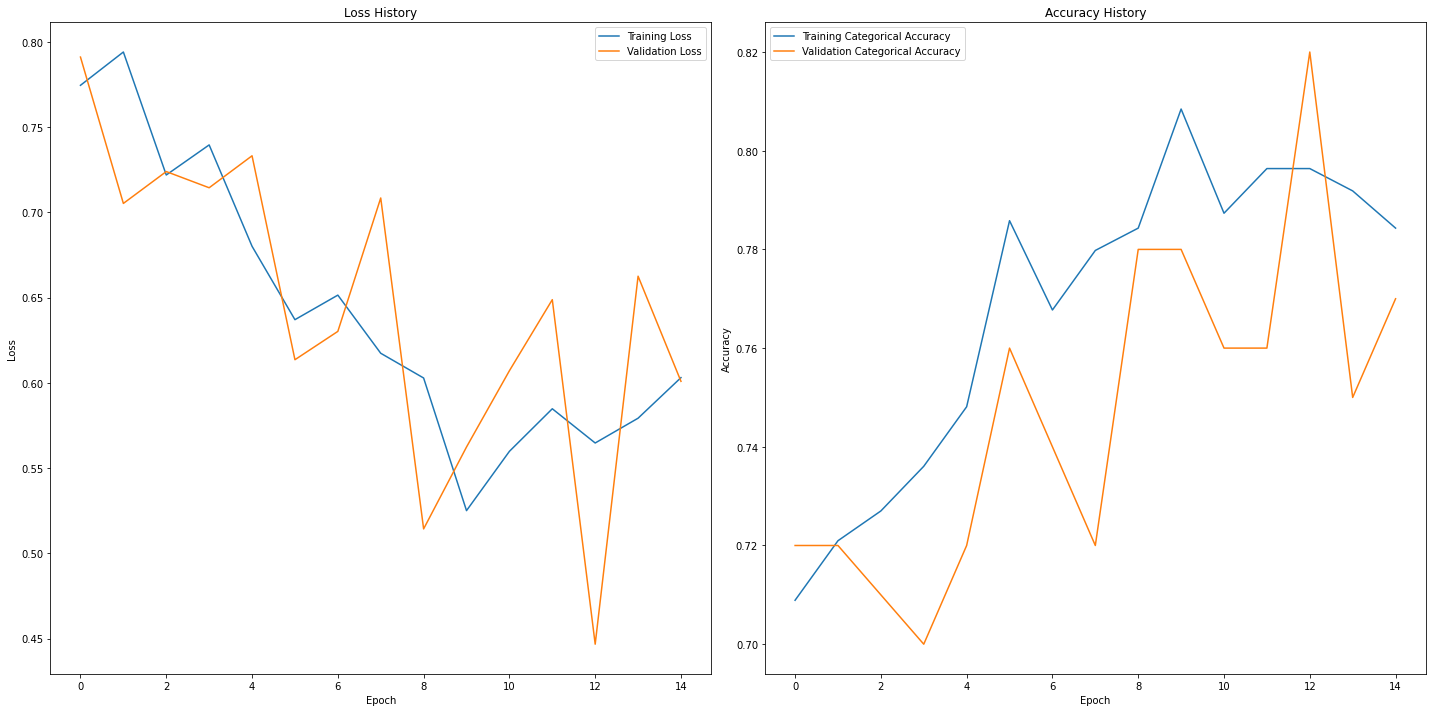

In [91]:
num_epochs = 15
history10_1 = model10.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plotHistory(history10_1)

/tmp/ipykernel_301/2875910173.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history10_2 = model10.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 0.5380 - categorical_accuracy: 0.8250
Epoch 00001: saving model to model_init_simple6_2023-07-0904_48_54.414710/model-00001-0.53798-0.82504-0.63988-0.74000.h5
21/21 [==============================] - 36s 2s/step - loss: 0.5380 - categorical_accuracy: 0.8250 - val_loss: 0.6399 - val_categorical_accuracy: 0.7400 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 0.5407 - categorical_accuracy: 0.7949
Epoch 00002: saving model to model_init_simple6_2023-07-0904_48_54.414710/model-00002-0.54073-0.79487-0.67122-0.73000.h5
21/21 [==============================] - 36s 2s/step - loss: 0.5407 - categorical_accuracy: 0.7949 - val_loss: 0.6712 - val_categorical_accuracy: 0.7300 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 0.4964 - categorical_accuracy: 0.8115
Epoch 00003: saving model to model_init_simple6_2023-07-0904_48_54.414710/model-00003-0.49641-0.81146-0.6004

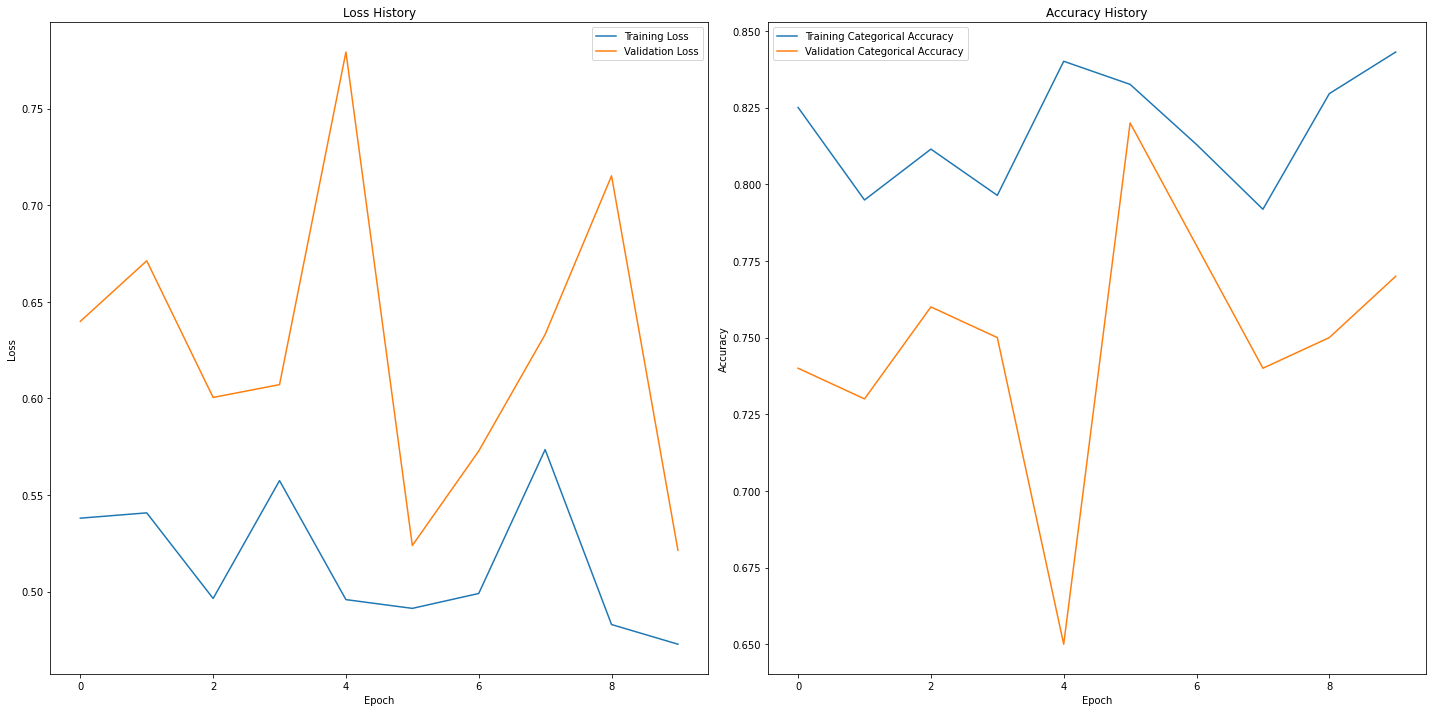

In [92]:
num_epochs = 10
history10_2 = model10.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plotHistory(history10_2)

/tmp/ipykernel_301/2447907454.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history10_3 = model10.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 0.4399 - categorical_accuracy: 0.8386
Epoch 00001: saving model to model_init_simple6_2023-07-0904_48_54.414710/model-00001-0.43987-0.83861-0.55834-0.82000.h5
21/21 [==============================] - 35s 2s/step - loss: 0.4399 - categorical_accuracy: 0.8386 - val_loss: 0.5583 - val_categorical_accuracy: 0.8200 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 0.4149 - categorical_accuracy: 0.8431
Epoch 00002: saving model to model_init_simple6_2023-07-0904_48_54.414710/model-00002-0.41492-0.84314-0.54363-0.80000.h5
21/21 [==============================] - 36s 2s/step - loss: 0.4149 - categorical_accuracy: 0.8431 - val_loss: 0.5436 - val_categorical_accuracy: 0.8000 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.4149 - categorical_accuracy: 0.8658
Epoch 00003: saving model to model_init_simple6_2023-07-0904_48_54.414710/model-00003-0.41489-0.86576-0.5864

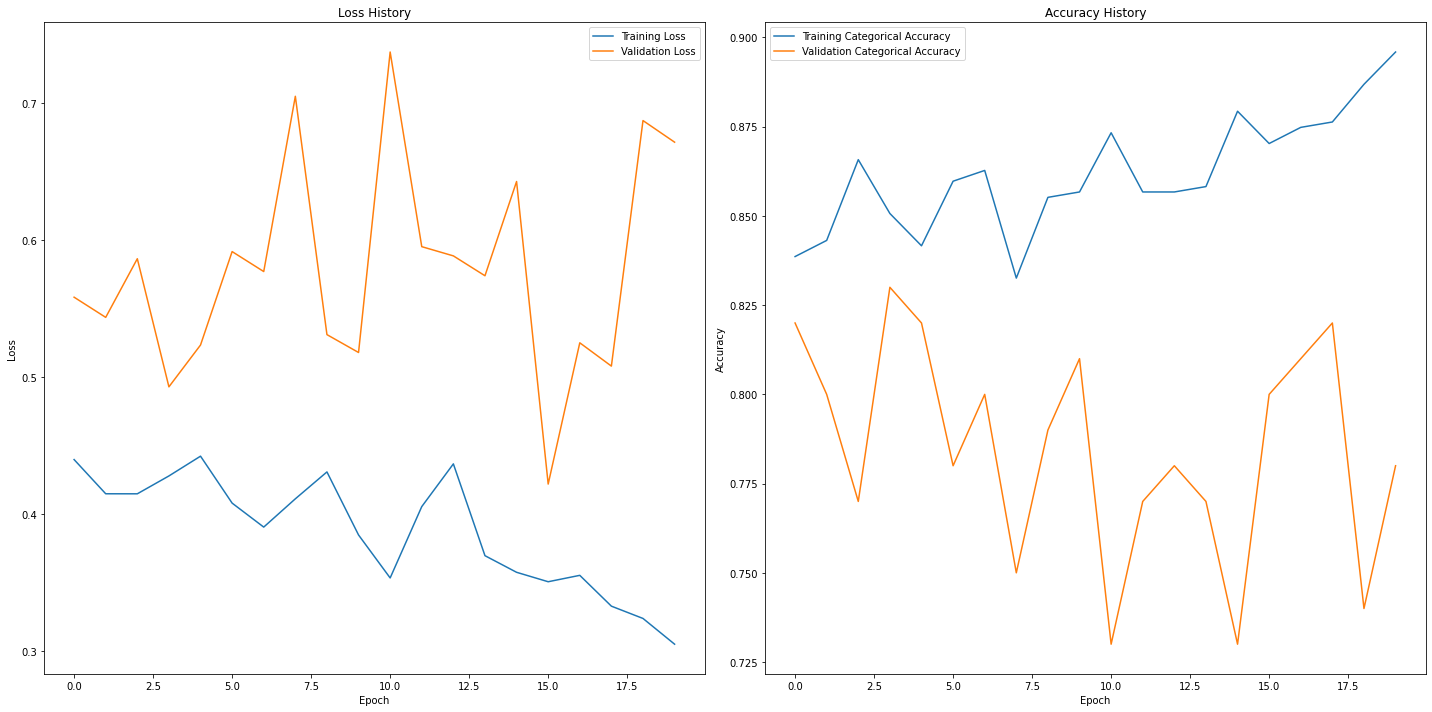

In [93]:
num_epochs = 20
history10_3 = model10.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plotHistory(history10_3)

/tmp/ipykernel_301/2193649850.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history10_4 = model10.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 0.3796 - categorical_accuracy: 0.8748
Epoch 00001: saving model to model_init_simple6_2023-07-0904_48_54.414710/model-00001-0.37957-0.87481-0.46947-0.82000.h5
21/21 [==============================] - 35s 2s/step - loss: 0.3796 - categorical_accuracy: 0.8748 - val_loss: 0.4695 - val_categorical_accuracy: 0.8200 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 0.3458 - categorical_accuracy: 0.8748
Epoch 00002: saving model to model_init_simple6_2023-07-0904_48_54.414710/model-00002-0.34579-0.87481-0.54418-0.81000.h5
21/21 [==============================] - 36s 2s/step - loss: 0.3458 - categorical_accuracy: 0.8748 - val_loss: 0.5442 - val_categorical_accuracy: 0.8100 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 0.4233 - categorical_accuracy: 0.8492
Epoch 00003: saving model to model_init_simple6_2023-07-0904_48_54.414710/model-00003-0.42329-0.84917-0.6381

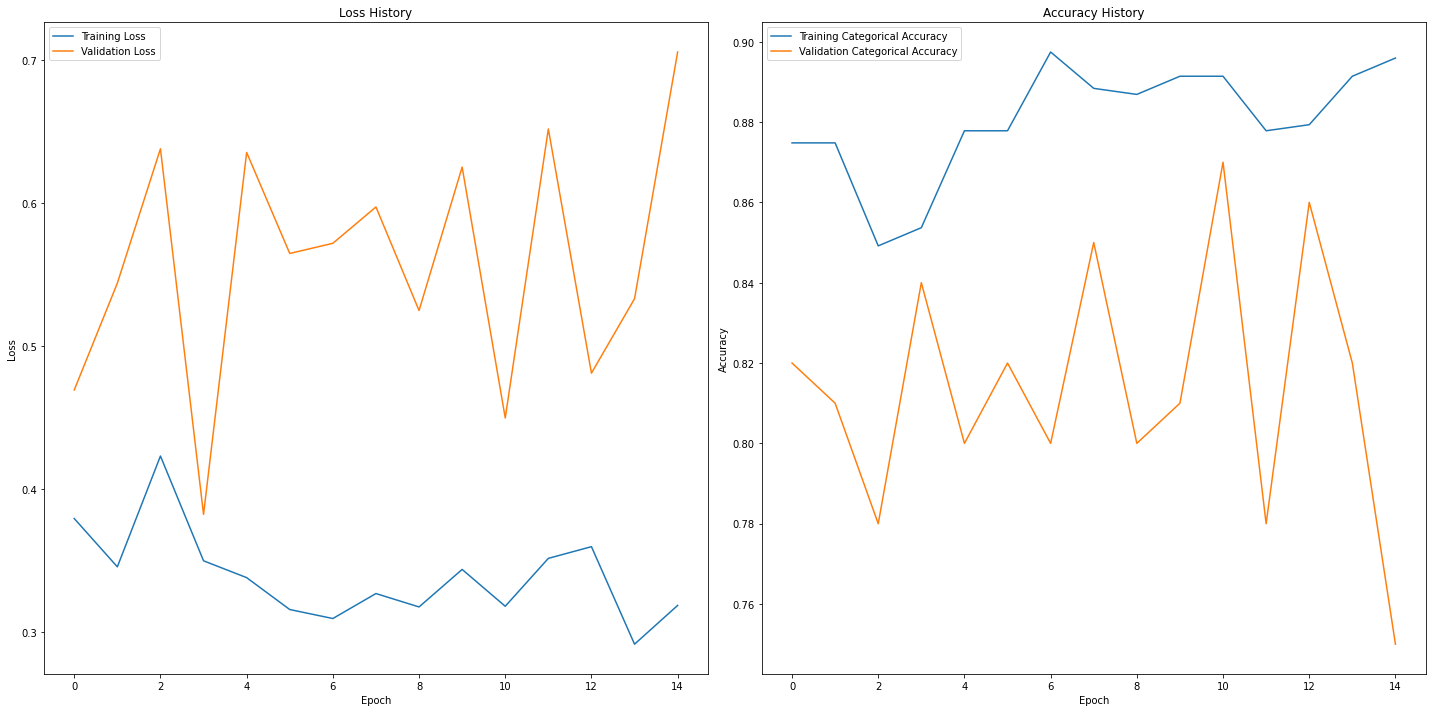

In [94]:
num_epochs = 15
history10_4 = model10.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plotHistory(history10_4)

/tmp/ipykernel_301/698709667.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history10_5 = model10.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 0.2920 - categorical_accuracy: 0.9020
Epoch 00001: saving model to model_init_simple6_2023-07-0904_48_54.414710/model-00001-0.29196-0.90196-0.46340-0.84000.h5
21/21 [==============================] - 37s 2s/step - loss: 0.2920 - categorical_accuracy: 0.9020 - val_loss: 0.4634 - val_categorical_accuracy: 0.8400 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 0.3285 - categorical_accuracy: 0.8899
Epoch 00002: saving model to model_init_simple6_2023-07-0904_48_54.414710/model-00002-0.32851-0.88989-0.48240-0.86000.h5
21/21 [==============================] - 35s 2s/step - loss: 0.3285 - categorical_accuracy: 0.8899 - val_loss: 0.4824 - val_categorical_accuracy: 0.8600 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 0.3318 - categorical_accuracy: 0.8808
Epoch 00003: saving model to model_init_simple6_2023-07-0904_48_54.414710/model-00003-0.33183-0.88084-0.4716

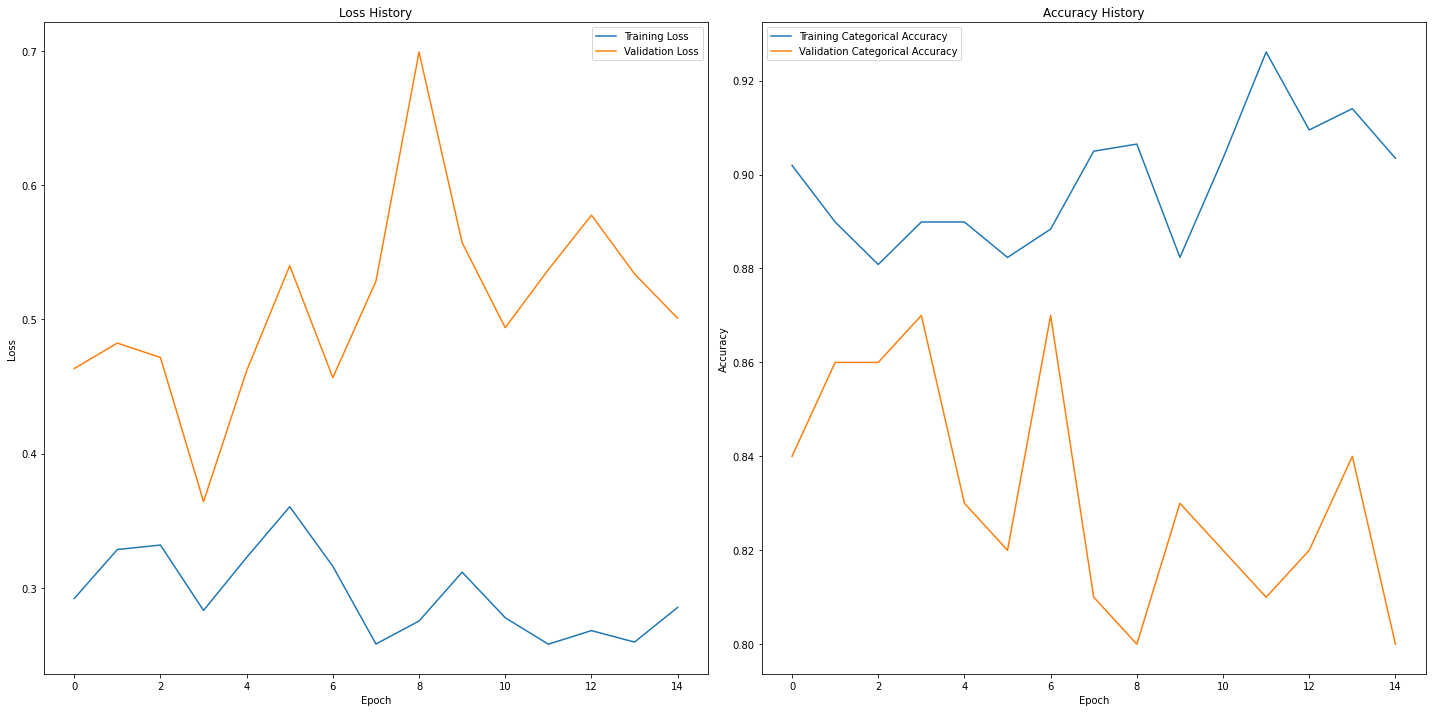

In [100]:
num_epochs = 15
history10_5 = model10.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plotHistory(history10_5)

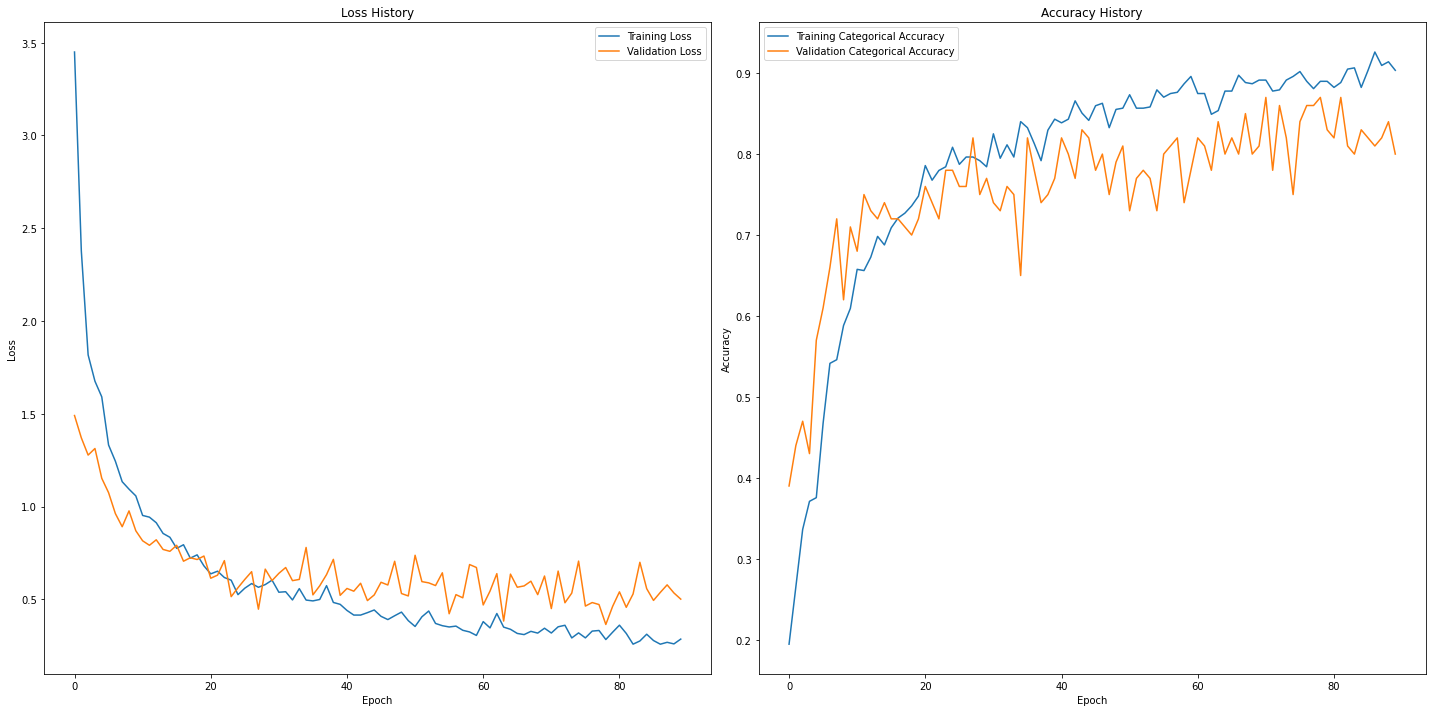

In [101]:
plotHistoryConc([history10,history10_1,history10_2,history10_3,history10_4,history10_5])

## Observation
1. Best model ~89% training and ~87% validation accuracies
2. Overfitting resolved
3. We have a very decent and light weight model
4. But can we get better results by mildly reducing regulaization?

## Todo
Decrease dropout and see impact

## Experiment 12: Reduce dropout

In [102]:
x = len(selected_frames)
y, z = dim_x, dim_y
input_shape = (x, y, z, 3)
num_classes = 5

model11 = Sequential()
model11.add(Conv3D(4, kernel_size=(4, 4, 4), activation='relu', input_shape=input_shape))#,kernel_regularizer=tf.keras.regularizers.l2(0.1)))
model11.add(MaxPooling3D(pool_size=(4, 4, 4)))
model11.add(Dropout(0.8))

# model0.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu'))
# model0.add(MaxPooling3D(pool_size=(2, 2, 2)))
model11.add(Flatten())
# model5.add(Dense(32, activation='relu'))
model11.add(Dense(num_classes, activation='softmax'))#, kernel_regularizer=tf.keras.regularizers.l2(0.01)))

In [103]:
optimiser = tf.keras.optimizers.Adam()#write your optimizer
model11.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model11.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_11 (Conv3D)          (None, 12, 97, 97, 4)     772       
                                                                 
 max_pooling3d_11 (MaxPoolin  (None, 3, 24, 24, 4)     0         
 g3D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 3, 24, 24, 4)      0         
                                                                 
 flatten_11 (Flatten)        (None, 6912)              0         
                                                                 
 dense_12 (Dense)            (None, 5)                 34565     
                                                                 
Total params: 35,337
Trainable params: 35,337
Non-trainable params: 0
_________________________________________________

In [104]:
model_size = get_model_size(model11)
print("Model size: {:.2f} MB".format(model_size / (1024 * 1024)))

Model size: 0.13 MB


In [105]:
model_name = 'model_init_simple7' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [106]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [107]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [108]:
num_epochs = 50
history11 = model11.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_301/2194413817.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history11 = model11.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 1.8244 - categorical_accuracy: 0.2428Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_simple7_2023-07-0904_48_54.414710/model-00001-1.82443-0.24284-1.55716-0.31000.h5
21/21 [==============================] - 34s 2s/step - loss: 1.8244 - categorical_accuracy: 0.2428 - val_loss: 1.5572 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.5037 - categorical_accuracy: 0.2383
Epoch 00002: saving model to model_init_simple7_2023-07-0904_48_54.414710/model-00002-1.50374-0.23831-1.38404-0.24000.h5
21/21 [==============================] - 34s 2s/step - loss: 1.5037 - categorical_accuracy: 0.2383 - val_loss: 1.3840 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 1.4298 - categ

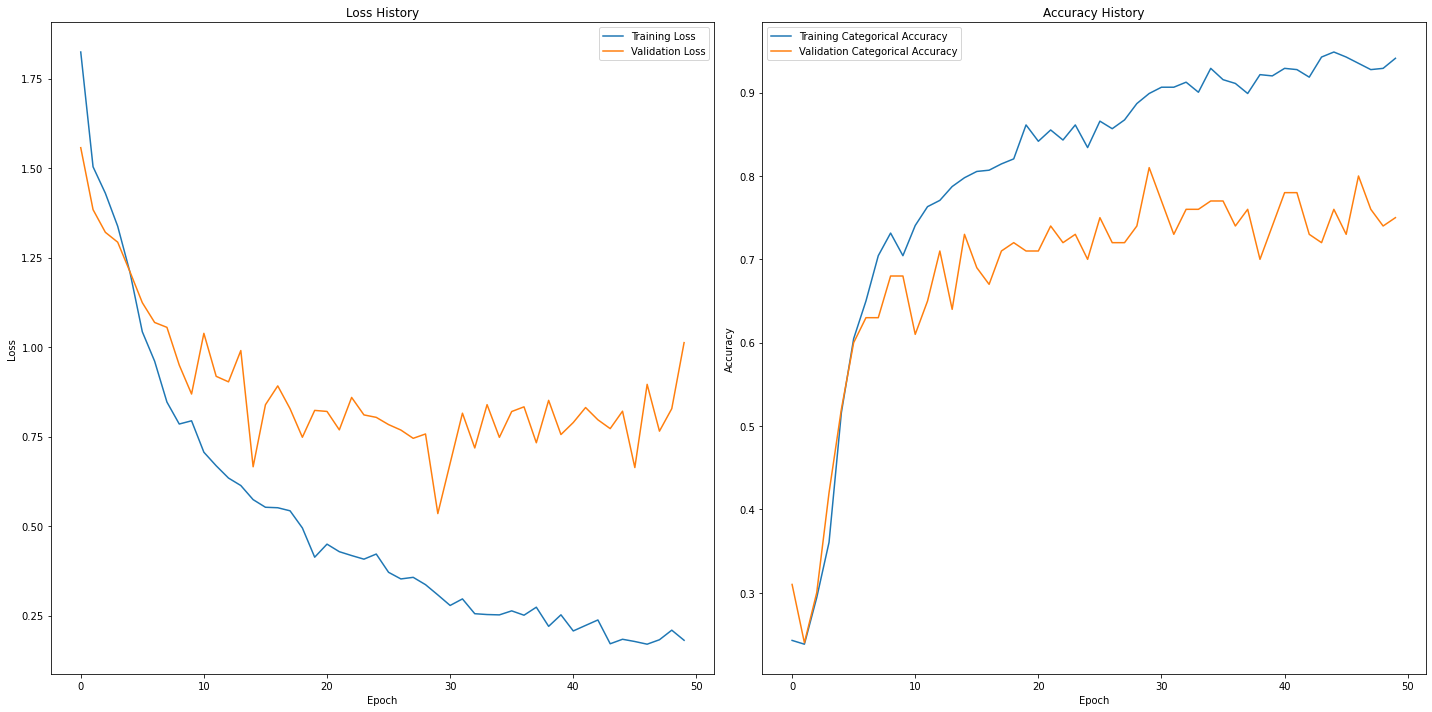

In [109]:
plotHistory(history11)

## OBSERVATION
1. best model 93% train 80% val
2. Overfitting even when dropout was dropped from 0.9 to 0.8

# THE BEST MODEL
Throughout the experiments, we have been simplifying the architecture, size and increasing regularization.
In our pursuit for the lightest and the best model, we have our best model with 89% training and 87% validation accuracy.
This was the simplest model conceivable with Conv3-based architectures.


```python
model = Sequential()
model.add(Conv3D(4, kernel_size=(4, 4, 4), activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=(4, 4, 4)))
model.add(Dropout(0.9))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
```

Now let's load the model, look at its size and shape

Model size: 0.13 MB


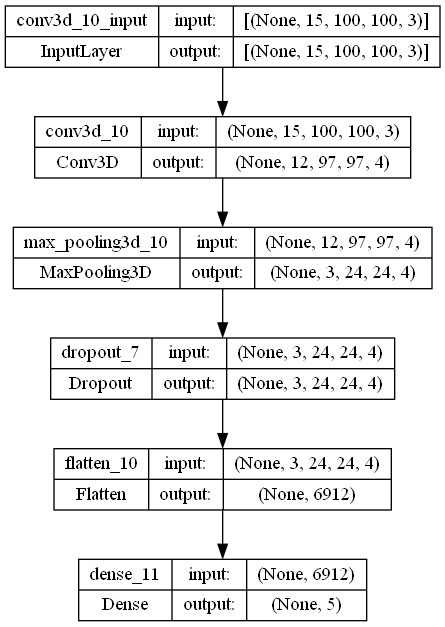

In [38]:
from keras.models import load_model
#graphviz required for below function (https://graphviz.org/download/)
from keras.utils.vis_utils import plot_model

## Insert the path of the best model below
best_model_path = "model-00011-0.31822-0.89140-0.44991-0.87000.h5"

best_model = load_model(best_model_path) 
best_model.save("best_model_0.89140-0.87000.h5")
model_size = get_model_size(best_model)
print("Model size: {:.2f} MB".format(model_size / (1024 * 1024)))
plot_model(best_model, to_file='best_model_plot.png', show_shapes=True, show_layer_names=True)

Our model is merely 0.13MB and can give about 89% and 87% accuracy on our training and validation data respectively. 

Such light weighing model would best suit for our real time application. Even our normalization process used is fast since we just directly divide by 255 without spending time on computing mean and stddev. This makes our model extremely fast in runtime.

Since this is a real time application of gesture recognition with quick movements, gesturing twice wouldn't be much of an inconvenience
and assuming an average accuracy of 88%, the probability of making error twice would be just ~1.4%. 

Which means that probability of getting it rightly recognized in atmost 2 attempts would be 98.6%, which is pretty high. 



### HENCE, OUR CURRENT MODEL IS PERFECTLY SUITABLE FOR THE ONLINE GESTURE RECOGNITION APPLICATION